In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pandas.tseries.offsets import MonthEnd
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.dates as mdates

# ARIMA Forecasting of Cubic Meter

In [137]:
df_arima = pd.read_csv('data4.csv', encoding='ISO-8859-1')
df_arima.head()

,Name,Present,Previous,CU.M.,Amount,Area_Number,Date,Initial
0,"Abainza, Jouie",1056,1051,5,130,1,2020-Jan,130
1,"Adam, Eduardo",NaN,NaN,NaN,NaN,1,2020-Jan,130
2,"Adam, Evelyn II",2178,2164,52,834,1,2020-Jan,130
3,"Agosto, Juanario",4167,4140,27,434,1,2020-Jan,130
4,"Albano, Gina",NaN,NaN,NaN,NaN,1,2020-Jan,130


In [138]:
df_arima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65011 entries, 0 to 65010
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         65009 non-null  object
 1   Present      59739 non-null  object
 2   Previous     59866 non-null  object
 3   CU.M.        60003 non-null  object
 4   Amount       59948 non-null  object
 5   Area_Number  65011 non-null  int64 
 6   Date         65011 non-null  object
 7   Initial      65011 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 4.0+ MB


In [139]:
df_arima['Present'] = pd.to_numeric(df_arima['Present'], errors='coerce').fillna(0).astype(int)
df_arima['Previous'] = pd.to_numeric(df_arima['Previous'], errors='coerce').fillna(0).astype(int)
df_arima['CU.M.'] = pd.to_numeric(df_arima['CU.M.'], errors='coerce').fillna(0).astype(int)
df_arima['Amount'] = pd.to_numeric(df_arima['Amount'], errors='coerce').fillna(0).astype(int)

# Check the result
print(df_arima.dtypes)
print(df_arima.head())
df_arima.info()

Name           object
Present         int32
Previous        int32
CU.M.           int32
Amount          int32
Area_Number     int64
Date           object
Initial         int64
dtype: object
               Name  Present  Previous  CU.M.  Amount  Area_Number      Date  \
0    Abainza, Jouie     1056      1051      5     130            1  2020-Jan   
1     Adam, Eduardo        0         0      0       0            1  2020-Jan   
2   Adam, Evelyn II     2178      2164     52     834            1  2020-Jan   
3  Agosto, Juanario     4167      4140     27     434            1  2020-Jan   
4      Albano, Gina        0         0      0       0            1  2020-Jan   

   Initial  
0      130  
1      130  
2      130  
3      130  
4      130  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65011 entries, 0 to 65010
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         65009 non-null  object
 1   Present      65

In [140]:
# Convert the Date column to datetime format
df_arima['Date'] = pd.to_datetime(df_arima['Date'], format='%Y-%b')

# Convert non-numeric columns to numeric (for both Amount and CU.M.), coercing errors and replacing NaN with 0
df_arima['Amount'] = pd.to_numeric(df_arima['Amount'], errors='coerce').fillna(0)
df_arima['CU.M.'] = pd.to_numeric(df_arima['CU.M.'], errors='coerce').fillna(0)

# Group by the Date and sum both Amount and CU.M. columns
monthly_sum = df_arima.groupby(df_arima['Date'].dt.to_period('M'))[['Amount', 'CU.M.']].sum().reset_index()

# Convert 'Date' back to a string with only Month and Year
monthly_sum['Date'] = monthly_sum['Date'].dt.strftime('%Y-%b')

# Round the Amount and CU.M. columns to 2 decimal places
monthly_sum['Amount'] = monthly_sum['Amount'].round(2)
monthly_sum['CU.M.'] = monthly_sum['CU.M.'].round(2)

# Display the result
print(monthly_sum)

        Date  Amount  CU.M.
0   2020-Jan  391814  24106
1   2020-Feb  384230  23574
2   2020-Mar  446286  26434
3   2020-Apr  424098  25970
4   2020-May  447320  30497
5   2020-Jun  444322  27419
6   2020-Jul  428278  26376
7   2020-Aug  414622  25478
8   2020-Sep  413302  25371
9   2020-Oct  410570  25183
10  2020-Nov  393536  24076
11  2020-Dec  383500  23464
12  2021-Jan  397710  24329
13  2021-Feb  464870  23212
14  2021-Mar  527832  26836
15  2021-Apr  513570  26061
16  2021-May  572876  29439
17  2021-Jun  496962  25059
18  2021-Jul  494514  24994
19  2021-Aug  511808  26000
20  2021-Sep  479242  24098
21  2021-Oct  495200  24973
22  2021-Nov  481448  24245
23  2021-Dec  491672  24779
24  2022-Jan  487490  24546
25  2022-Feb  491780  24236
26  2022-Mar  507728  25734
27  2022-Apr  497378  25179
28  2022-May  524186  26777
29  2022-Jun  504590  25645
30  2022-Jul  516710  26301
31  2022-Aug  520412  26505
32  2022-Sep  501054  25377
33  2022-Oct  514356  26073
34  2022-Nov  522000

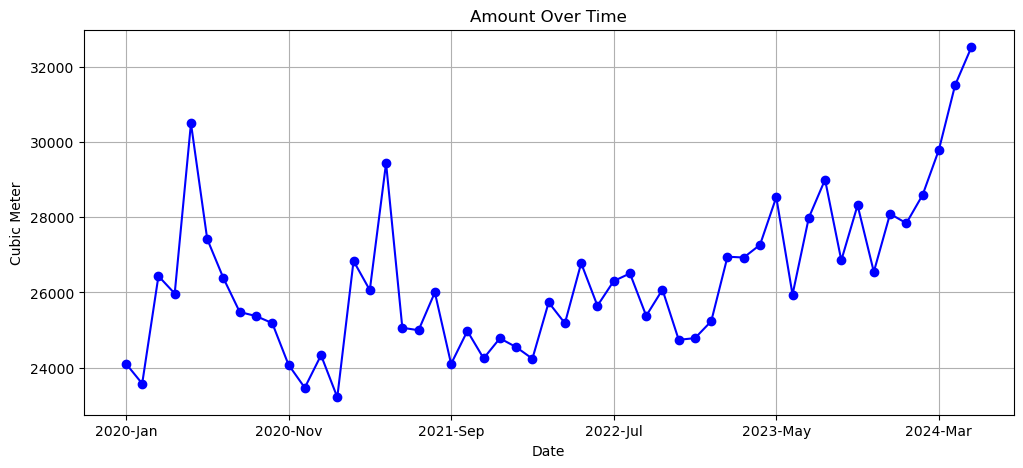

In [141]:
monthly_sum.set_index('Date', inplace=True)
# Plot the Amount column
monthly_sum['CU.M.'].plot(figsize=(12, 5), title="Amount Over Time", color='blue', marker='o')

# Add labels
plt.xlabel('Date')
plt.ylabel('Cubic Meter')
plt.grid(True)
plt.show()

In [123]:
def check_stationarity(timeseries):
    adf_test = adfuller(timeseries, autolag='AIC')
    adf_statistic = adf_test[0]
    p_value = adf_test[1]
    print(f'ADF Statistic: {adf_statistic}')
    print(f'p-value: {p_value}')
    
    if p_value < 0.05:
        print("The time series is stationary.")
    else:
        print("The time series is not stationary.")

# Check stationarity of the 'Cubic Meter' column
check_stationarity(monthly_sum['CU.M.'])

ADF Statistic: 4.321783710309527
p-value: 1.0
The time series is not stationary.


# Differencing (Seasonal)

In [151]:
# First-order differencing
first_diff = monthly_sum['CU.M.'].diff().dropna()
check_stationarity(first_diff)

# Seasonal differencing (if you have monthly data with seasonal patterns)
seasonal_diff = monthly_sum['CU.M.'].diff(periods=12).dropna()
check_stationarity(seasonal_diff)


ADF Statistic: -0.5866256274477656
p-value: 0.8739755396857938
The time series is not stationary.
ADF Statistic: -2.2320323586936155
p-value: 0.19482560075032285
The time series is not stationary.


In [152]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

stepwise_fit = auto_arima(
    seasonal_diff.dropna(),
    seasonal=False, 
    stepwise=True,
    trace=True,
    suppress_warnings=True
)

# Print the summary of the model
print(stepwise_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=685.055, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=682.438, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=683.299, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=682.446, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=674.723, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=678.248, Time=0.04 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.733 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   41
Model:               SARIMA

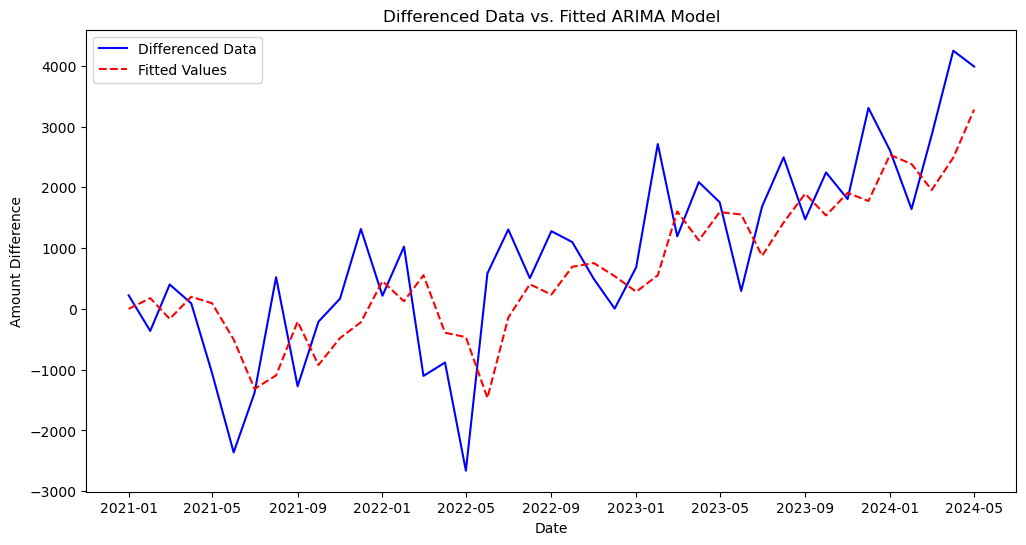

In [153]:
# Convert index to datetime format if not already
monthly_sum.index = pd.to_datetime(monthly_sum.index, format='%Y-%b')

# Fit the ARIMA model to the differenced data
model = ARIMA(seasonal_diff.dropna(), order=(1, 1, 1))  # Adjust order as needed
model_fit = model.fit()

# Extract the fitted values
fitted_values = model_fit.fittedvalues

# Plot the differenced data and fitted values
plt.figure(figsize=(12, 6))

# Plot the original differenced data
plt.plot(seasonal_diff, label='Differenced Data', color='blue')

# Plot the fitted values from the ARIMA model
plt.plot(fitted_values, label='Fitted Values', color='red', linestyle='--')

# Add title, labels, and legend
plt.title('Differenced Data vs. Fitted ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Amount Difference')
plt.legend()

# Show the plot
plt.show()

In [154]:
# Align the index of the fitted values with the original differenced data
fitted_values = pd.Series(fitted_values, index=seasonal_diff.dropna().index)

# Calculate the residuals
residuals = seasonal_diff.dropna() - fitted_values

# Calculate MSE, RMSE, and MAE
mse = mean_squared_error(seasonal_diff.dropna(), fitted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(seasonal_diff.dropna(), fitted_values)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

MSE: 1132234.7085634815
RMSE: 1064.0651805991404
MAE: 868.2909137563902


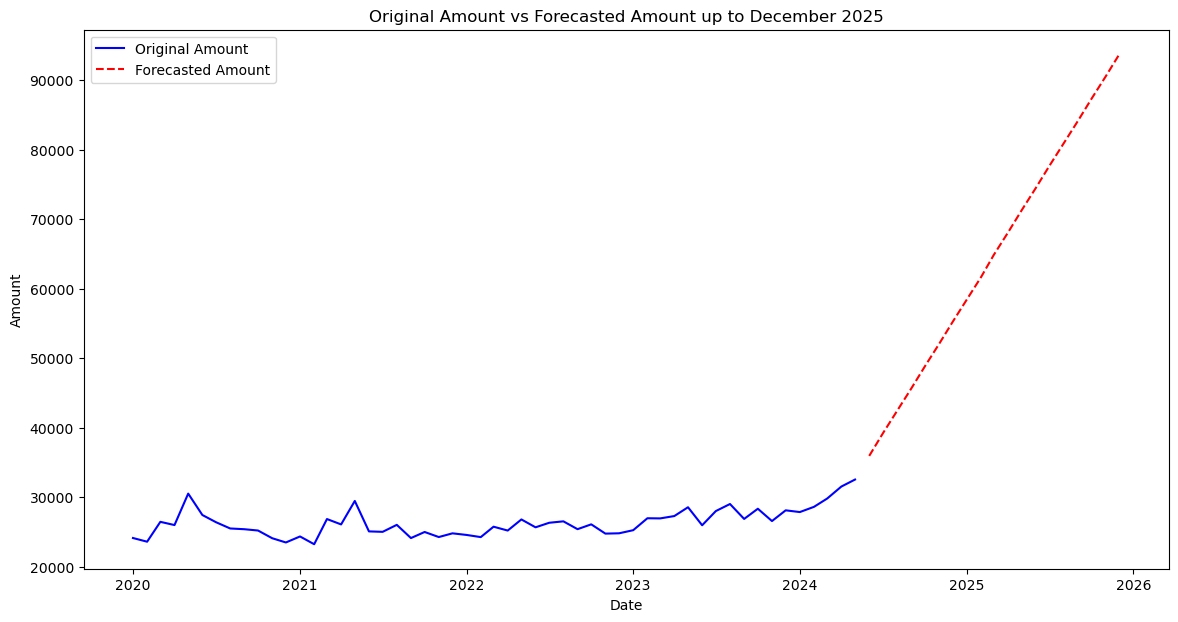

                Forecast
2024-06-01  35919.640806
2024-07-01  39174.313029
2024-08-01  42393.816627
2024-09-01  45604.729237
2024-10-01  48813.543243
2024-11-01  52021.844601
2024-12-01  55230.020730
2025-01-01  58438.166269
2025-02-01  61646.304334
2025-03-01  64854.440574
2025-04-01  68062.576368
2025-05-01  71270.712053
2025-06-01  74478.847712
2025-07-01  77686.983364
2025-08-01  80895.119014
2025-09-01  84103.254664
2025-10-01  87311.390314
2025-11-01  90519.525964
2025-12-01  93727.661614


In [155]:
# Assuming monthly_sum and model_fit are already defined

# Generate future dates up to December 2025
future_dates = pd.date_range(start=monthly_sum.index[-1] + pd.DateOffset(months=1), end='2025-12', freq='MS')

# Forecast future values
forecast = model_fit.get_forecast(steps=len(future_dates))

# Extract forecasted values
forecast_values = forecast.predicted_mean

# Optional: Extract forecast confidence intervals
forecast_conf_int = forecast.conf_int()

# Create a DataFrame for the forecast
forecast_df = pd.DataFrame({'Forecast_diff': forecast_values}, index=future_dates)

# Use the last known amount value for the forecast start
last_known_amount = monthly_sum['CU.M.'].iloc[-1]

# Reconstruct the forecasted amount
# Check for NaNs and handle them
forecast_df['Forecast_diff'] = forecast_df['Forecast_diff'].fillna(0)  # Replace NaNs with 0 if appropriate

forecast_df['Forecast'] = last_known_amount + forecast_df['Forecast_diff'].cumsum()

# Plot original Amount and reconstructed forecast
plt.figure(figsize=(14, 7))

# Plot original Amount
plt.plot(monthly_sum.index, monthly_sum['CU.M.'], label='Original Amount', color='blue')

# Plot reconstructed forecast up to December 2025
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecasted Amount', color='red', linestyle='--')

plt.title('Original Amount vs Forecasted Amount up to December 2025')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend()
plt.show()

# Print forecast DataFrame to check the forecast
print(forecast_df[['Forecast']])


# Differencing (Second)

In [156]:
# First-order differencing
first_diff = monthly_sum['CU.M.'].diff().dropna()

# Second-order differencing
second_diff = first_diff.diff().dropna()

check_stationarity(second_diff)

ADF Statistic: -7.110015087522493
p-value: 3.9613843600050266e-10
The time series is stationary.


In [157]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

stepwise_fit = auto_arima(
    second_diff.dropna(),
    seasonal=False, 
    stepwise=True,
    trace=True,
    suppress_warnings=True
)

# Print the summary of the model
print(stepwise_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=956.915, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=914.500, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=907.578, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=909.189, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=909.571, Time=0.02 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0]          
Total fit time: 0.363 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   51
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -450.789
Date:        

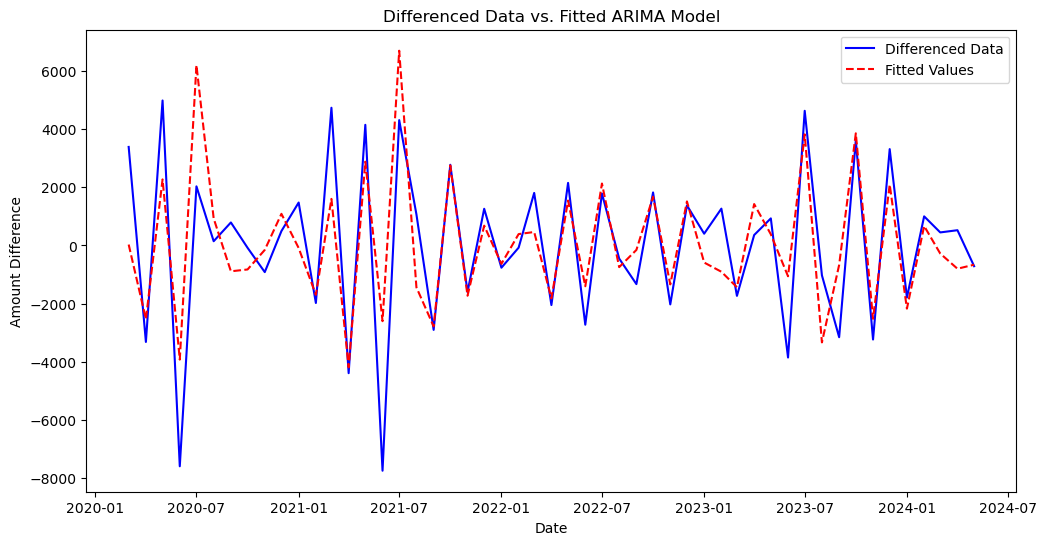

In [158]:
# Convert index to datetime format if not already
monthly_sum.index = pd.to_datetime(monthly_sum.index, format='%Y-%b')

# Fit the ARIMA model to the differenced data
model = ARIMA(second_diff.dropna(), order=(2, 0, 0))  # Adjust order as needed
model_fit = model.fit()

# Extract the fitted values
fitted_values = model_fit.fittedvalues

# Plot the differenced data and fitted values
plt.figure(figsize=(12, 6))

# Plot the original differenced data
plt.plot(second_diff, label='Differenced Data', color='blue')

# Plot the fitted values from the ARIMA model
plt.plot(fitted_values, label='Fitted Values', color='red', linestyle='--')

# Add title, labels, and legend
plt.title('Differenced Data vs. Fitted ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Amount Difference')
plt.legend()

# Show the plot
plt.show()

In [159]:
# Calculate MSE
mse = mean_squared_error(second_diff.dropna(), fitted_values)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate RMSE
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calculate MAE
mae = mean_absolute_error(second_diff.dropna(), fitted_values)
print(f'Mean Absolute Error (MAE): {mae}')

Mean Squared Error (MSE): 2868386.9311666572
Root Mean Squared Error (RMSE): 1693.6312854829582
Mean Absolute Error (MAE): 1216.228606551745


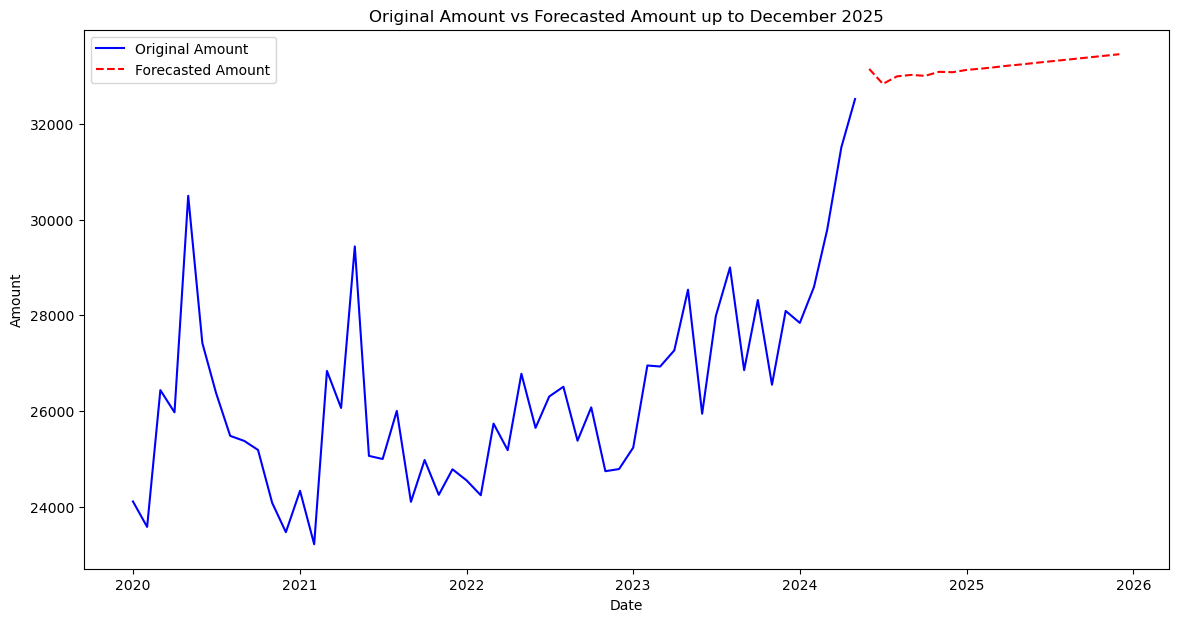

                Forecast
2024-06-01  33150.275990
2024-07-01  32837.547527
2024-08-01  32995.324793
2024-09-01  33025.865908
2024-10-01  33004.876630
2024-11-01  33089.591910
2024-12-01  33081.954326
2025-01-01  33130.834616
2025-02-01  33156.145700
2025-03-01  33184.114485
2025-04-01  33218.632733
2025-05-01  33245.098553
2025-06-01  33277.554581
2025-07-01  33306.821177
2025-08-01  33337.107753
2025-09-01  33367.575474
2025-10-01  33397.443505
2025-11-01  33427.879769
2025-12-01  33457.948096


In [160]:
# Assuming monthly_sum and model_fit are already defined

# Generate future dates up to December 2025
future_dates = pd.date_range(start=monthly_sum.index[-1] + pd.DateOffset(months=1), end='2025-12', freq='MS')

# Forecast future values
forecast = model_fit.get_forecast(steps=len(future_dates))

# Extract forecasted values
forecast_values = forecast.predicted_mean

# Optional: Extract forecast confidence intervals
forecast_conf_int = forecast.conf_int()

# Create a DataFrame for the forecast
forecast_df = pd.DataFrame({'Forecast_diff': forecast_values}, index=future_dates)

# Use the last known amount value for the forecast start
last_known_amount = monthly_sum['CU.M.'].iloc[-1]

# Reconstruct the forecasted amount
# Check for NaNs and handle them
forecast_df['Forecast_diff'] = forecast_df['Forecast_diff'].fillna(0)  # Replace NaNs with 0 if appropriate

forecast_df['Forecast'] = last_known_amount + forecast_df['Forecast_diff'].cumsum()

# Plot original Amount and reconstructed forecast
plt.figure(figsize=(14, 7))

# Plot original Amount
plt.plot(monthly_sum.index, monthly_sum['CU.M.'], label='Original Amount', color='blue')

# Plot reconstructed forecast up to December 2025
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecasted Amount', color='red', linestyle='--')

plt.title('Original Amount vs Forecasted Amount up to December 2025')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend()
plt.show()

# Print forecast DataFrame to check the forecast
print(forecast_df[['Forecast']])


# Log

In [161]:
# Log transformation
log_data = np.log(monthly_sum['CU.M.'])
check_stationarity(log_data)


ADF Statistic: 4.10018992828668
p-value: 1.0
The time series is not stationary.


# Detrending

In [162]:
from scipy import signal

# Linear detrending
detrended = signal.detrend(monthly_sum['CU.M.'])
check_stationarity(pd.Series(detrended))

ADF Statistic: -1.81497839309725
p-value: 0.37305110123913915
The time series is not stationary.


In [163]:
import pandas as pd
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

# Convert detrended to a pandas Series if it's currently a numpy array
detrended_series = pd.Series(detrended)

# Drop missing values if any
detrended_series = detrended_series.dropna()

# Fit the ARIMA model using auto_arima
stepwise_fit = auto_arima(
    detrended_series,
    seasonal=False, 
    stepwise=True,
    trace=True,
    suppress_warnings=True
)

# Print the summary of the model
print(stepwise_fit.summary())


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=924.679, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=940.708, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=926.823, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=934.044, Time=0.00 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=922.163, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=922.021, Time=0.02 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=922.960, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=926.899, Time=0.02 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=924.137, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=924.251, Time=0.03 sec

Best model:  ARIMA(0,0,2)(0,0,0)[0]          
Total fit time: 0.315 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   53
Model:               SARIMAX(0, 0, 2)   Log Likelihood                -4

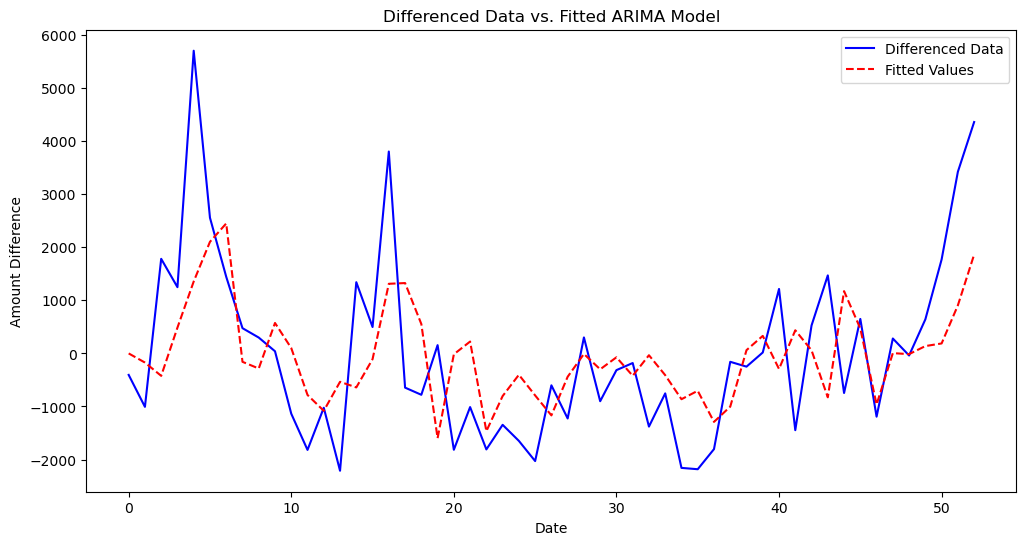

In [164]:
# Convert index to datetime format if not already
monthly_sum.index = pd.to_datetime(monthly_sum.index, format='%Y-%b')

# Fit the ARIMA model to the differenced data
model = ARIMA(detrended_series, order=(0, 0, 2))  # Adjust order as needed
model_fit = model.fit()

# Extract the fitted values
fitted_values = model_fit.fittedvalues

# Plot the differenced data and fitted values
plt.figure(figsize=(12, 6))

# Plot the original differenced data
plt.plot(detrended_series, label='Differenced Data', color='blue')

# Plot the fitted values from the ARIMA model
plt.plot(fitted_values, label='Fitted Values', color='red', linestyle='--')

# Add title, labels, and legend
plt.title('Differenced Data vs. Fitted ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Amount Difference')
plt.legend()

# Show the plot
plt.show()

In [165]:
# Calculate the accuracy metrics
mse = mean_squared_error(detrended_series, fitted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(detrended_series, fitted_values)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

MSE: 1875210.824479157
RMSE: 1369.3833738143446
MAE: 1083.0755280337844


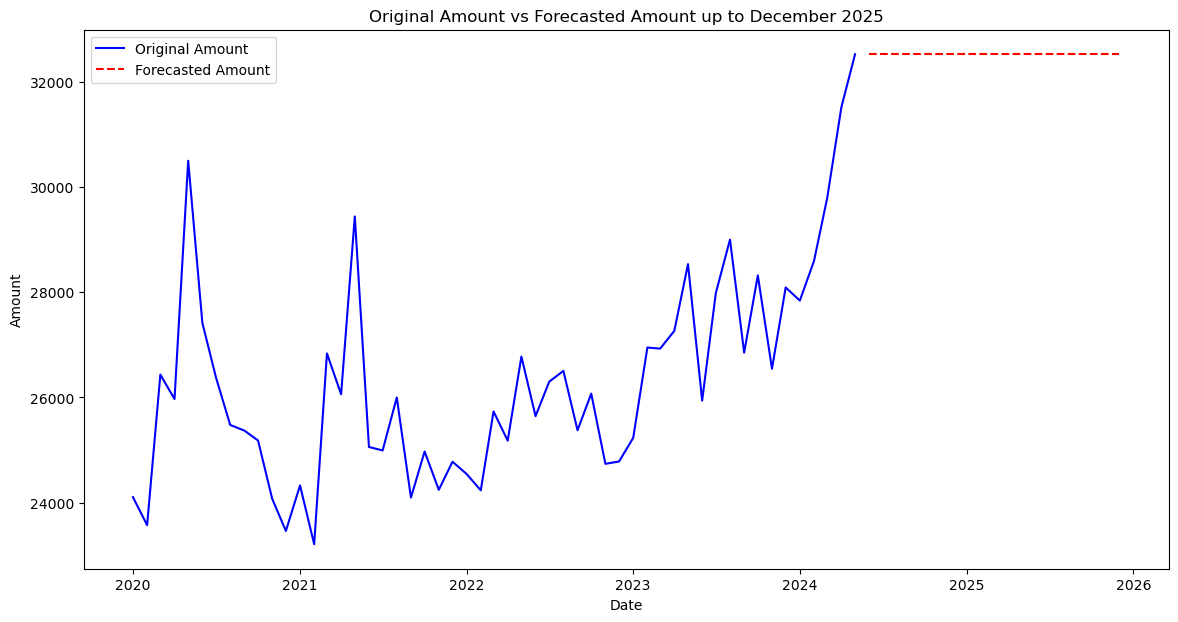

            Forecast
2024-06-01   32521.0
2024-07-01   32521.0
2024-08-01   32521.0
2024-09-01   32521.0
2024-10-01   32521.0
2024-11-01   32521.0
2024-12-01   32521.0
2025-01-01   32521.0
2025-02-01   32521.0
2025-03-01   32521.0
2025-04-01   32521.0
2025-05-01   32521.0
2025-06-01   32521.0
2025-07-01   32521.0
2025-08-01   32521.0
2025-09-01   32521.0
2025-10-01   32521.0
2025-11-01   32521.0
2025-12-01   32521.0


In [166]:
# Assuming monthly_sum and model_fit are already defined

# Generate future dates up to December 2025
future_dates = pd.date_range(start=monthly_sum.index[-1] + pd.DateOffset(months=1), end='2025-12', freq='MS')

# Forecast future values
forecast = model_fit.get_forecast(steps=len(future_dates))

# Extract forecasted values
forecast_values = forecast.predicted_mean

# Optional: Extract forecast confidence intervals
forecast_conf_int = forecast.conf_int()

# Create a DataFrame for the forecast
forecast_df = pd.DataFrame({'Forecast_diff': forecast_values}, index=future_dates)

# Use the last known amount value for the forecast start
last_known_amount = monthly_sum['CU.M.'].iloc[-1]

# Reconstruct the forecasted amount
# Check for NaNs and handle them
forecast_df['Forecast_diff'] = forecast_df['Forecast_diff'].fillna(0)  # Replace NaNs with 0 if appropriate

forecast_df['Forecast'] = last_known_amount + forecast_df['Forecast_diff'].cumsum()

# Plot original Amount and reconstructed forecast
plt.figure(figsize=(14, 7))

# Plot original Amount
plt.plot(monthly_sum.index, monthly_sum['CU.M.'], label='Original Amount', color='blue')

# Plot reconstructed forecast up to December 2025
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecasted Amount', color='red', linestyle='--')

plt.title('Original Amount vs Forecasted Amount up to December 2025')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend()
plt.show()

# Print forecast DataFrame to check the forecast
print(forecast_df[['Forecast']])


# Seasonal Decomposition

In [167]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
decomposition = seasonal_decompose(monthly_sum['CU.M.'], model='additive', period=12)

# Extract the residual component (this should be stationary if trend and seasonality are removed)
residual = decomposition.resid.dropna()
check_stationarity(residual)


ADF Statistic: -4.666574725277962
p-value: 9.719927405210291e-05
The time series is stationary.


In [171]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

stepwise_fit2 = auto_arima(
    residual.dropna(),
    seasonal=False, 
    stepwise=True,
    trace=True,
    suppress_warnings=True
)

# Print the summary of the model
print(stepwise_fit2.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=648.217, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=650.005, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=650.027, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=651.995, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=649.276, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.181 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   41
Model:                        SARIMAX   Log Likelihood                -323.109
Date:                Fri, 06 Sep 2024   AIC                            648.217
Time:                        23:37:37   BIC                            649.931
Sample:                    07-01-2020   HQIC                           648.841
                    

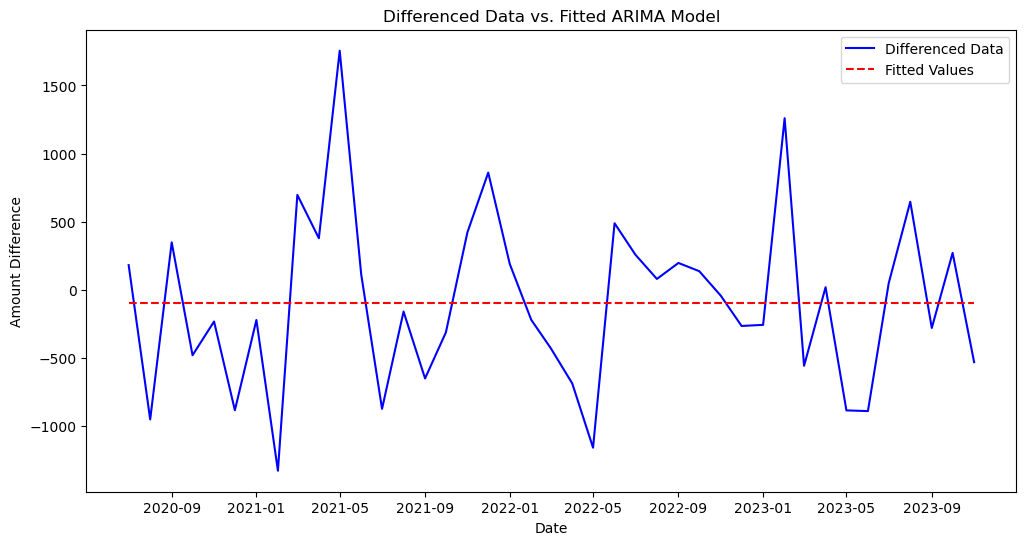

In [172]:
# Convert index to datetime format if not already
monthly_sum.index = pd.to_datetime(monthly_sum.index, format='%Y-%b')

# Fit the ARIMA model to the differenced data
model = ARIMA(residual.dropna(), order=(0, 0, 0))  # Adjust order as needed
model_fit = model.fit()

# Extract the fitted values
fitted_values = model_fit.fittedvalues

# Plot the differenced data and fitted values
plt.figure(figsize=(12, 6))

# Plot the original differenced data
plt.plot(residual, label='Differenced Data', color='blue')

# Plot the fitted values from the ARIMA model
plt.plot(fitted_values, label='Fitted Values', color='red', linestyle='--')

# Add title, labels, and legend
plt.title('Differenced Data vs. Fitted ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Amount Difference')
plt.legend()

# Show the plot
plt.show()

In [173]:
mse = mean_squared_error(residual.dropna(), fitted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(residual.dropna(), fitted_values)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

MSE: 400540.15206541243
RMSE: 632.8824156708831
MAE: 499.13416231467113


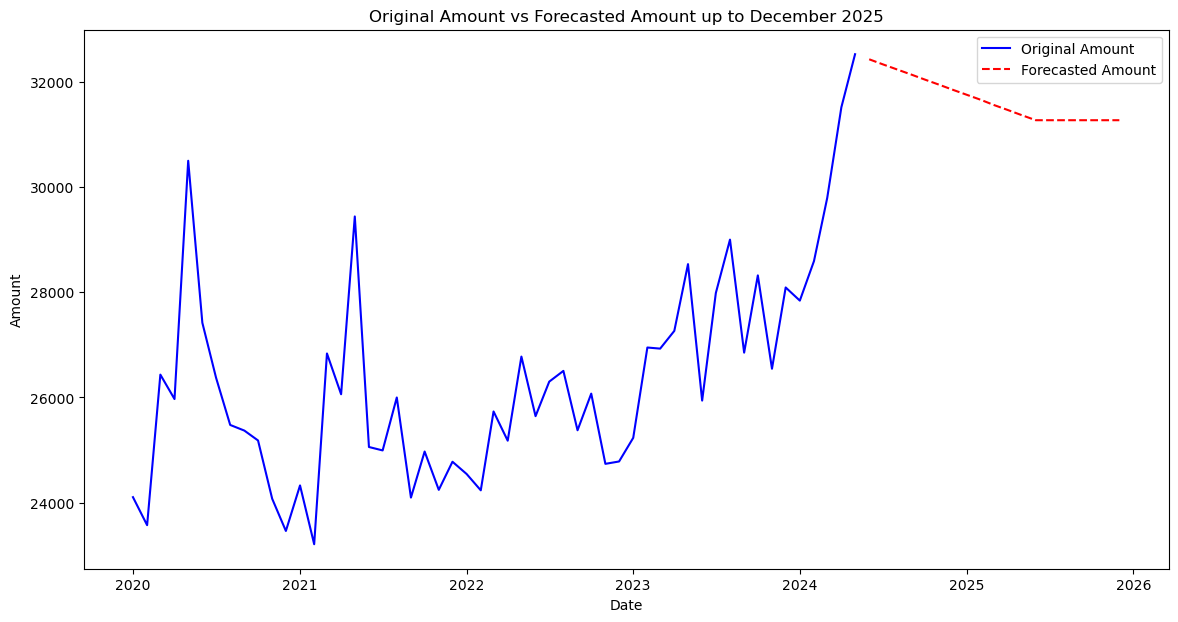

                Forecast
2024-06-01  32424.564312
2024-07-01  32328.128625
2024-08-01  32231.692937
2024-09-01  32135.257249
2024-10-01  32038.821562
2024-11-01  31942.385874
2024-12-01  31845.950186
2025-01-01  31749.514498
2025-02-01  31653.078811
2025-03-01  31556.643123
2025-04-01  31460.207435
2025-05-01  31363.771748
2025-06-01  31267.336060
2025-07-01  31267.336060
2025-08-01  31267.336060
2025-09-01  31267.336060
2025-10-01  31267.336060
2025-11-01  31267.336060
2025-12-01  31267.336060


In [174]:
# Assuming monthly_sum and model_fit are already defined

# Generate future dates up to December 2025
future_dates = pd.date_range(start=monthly_sum.index[-1] + pd.DateOffset(months=1), end='2025-12', freq='MS')

# Forecast future values
forecast = model_fit.get_forecast(steps=len(future_dates))

# Extract forecasted values
forecast_values = forecast.predicted_mean

# Optional: Extract forecast confidence intervals
forecast_conf_int = forecast.conf_int()

# Create a DataFrame for the forecast
forecast_df = pd.DataFrame({'Forecast_diff': forecast_values}, index=future_dates)

# Use the last known amount value for the forecast start
last_known_amount = monthly_sum['CU.M.'].iloc[-1]

# Reconstruct the forecasted amount
# Check for NaNs and handle them
forecast_df['Forecast_diff'] = forecast_df['Forecast_diff'].fillna(0)  # Replace NaNs with 0 if appropriate

forecast_df['Forecast'] = last_known_amount + forecast_df['Forecast_diff'].cumsum()

# Plot original Amount and reconstructed forecast
plt.figure(figsize=(14, 7))

# Plot original Amount
plt.plot(monthly_sum.index, monthly_sum['CU.M.'], label='Original Amount', color='blue')

# Plot reconstructed forecast up to December 2025
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecasted Amount', color='red', linestyle='--')

plt.title('Original Amount vs Forecasted Amount up to December 2025')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend()
plt.show()

# Print forecast DataFrame to check the forecast
print(forecast_df[['Forecast']])


# Not Applying Stationary Process

In [175]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

stepwise_fit = auto_arima(
    monthly_sum['CU.M.'].dropna(),
    seasonal=True, 
    stepwise=True,
    trace=True,
    suppress_warnings=True
)

# Print the summary of the model
print(stepwise_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=919.934, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=921.120, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=917.992, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=919.257, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=919.632, Time=0.00 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=914.880, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=916.841, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=916.798, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=916.934, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=919.504, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=913.368, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=917.269, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=915.360, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=915.987, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=914.6

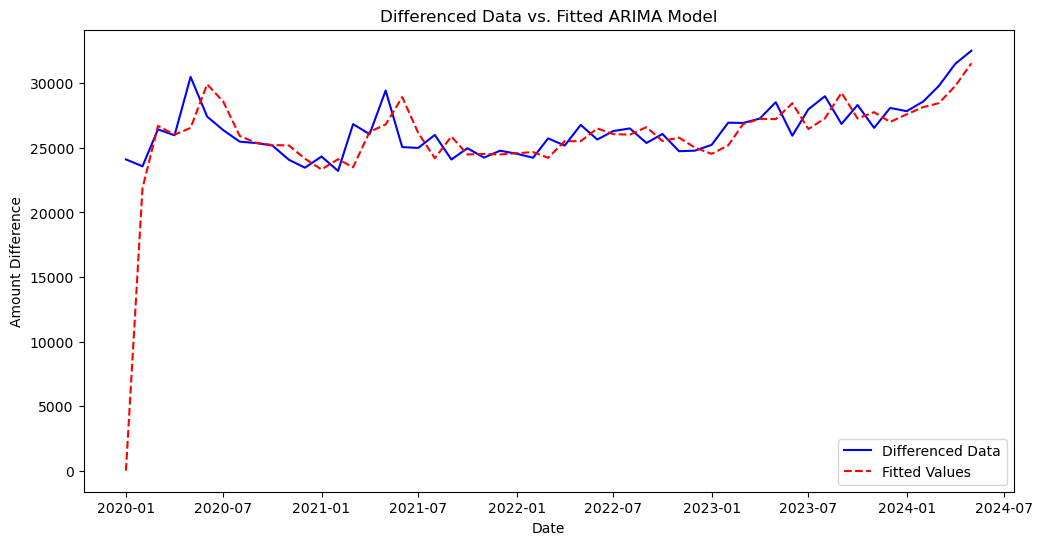

In [176]:
# Convert index to datetime format if not already
monthly_sum.index = pd.to_datetime(monthly_sum.index, format='%Y-%b')

# Fit the ARIMA model to the differenced data
model = ARIMA(monthly_sum['CU.M.'].dropna(), order=(2, 1, 0))  # Adjust order as needed
model_fit = model.fit()

# Extract the fitted values
fitted_values = model_fit.fittedvalues

# Plot the differenced data and fitted values
plt.figure(figsize=(12, 6))

# Plot the original differenced data
plt.plot(monthly_sum['CU.M.'], label='Differenced Data', color='blue')

# Plot the fitted values from the ARIMA model
plt.plot(fitted_values, label='Fitted Values', color='red', linestyle='--')

# Add title, labels, and legend
plt.title('Differenced Data vs. Fitted ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Amount Difference')
plt.legend()

# Show the plot
plt.show()

In [177]:
# Calculate the accuracy metrics
mse = mean_squared_error(monthly_sum['CU.M.'], fitted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(monthly_sum['CU.M.'], fitted_values)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

MSE: 13138372.567625493
RMSE: 3624.6893063579246
MAE: 1568.0437241945972


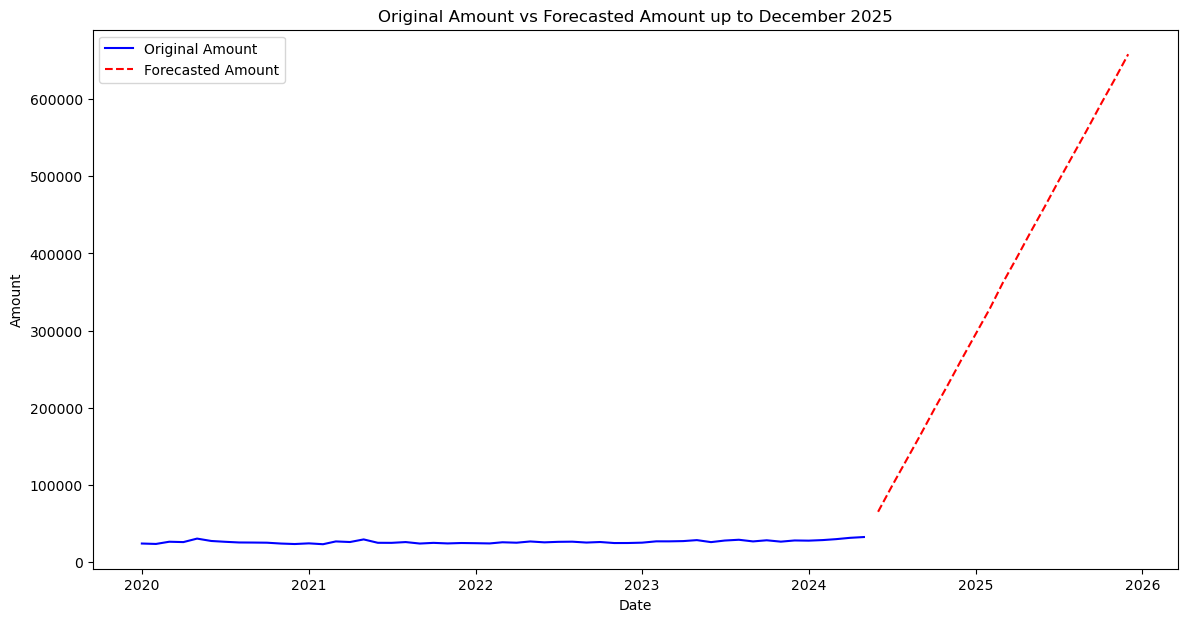

                 Forecast
2024-06-01   65249.318327
2024-07-01   98140.468041
2024-08-01  131052.049483
2024-09-01  163991.353280
2024-10-01  196931.402246
2024-11-01  229876.467964
2024-12-01  262821.125660
2025-01-01  295766.750188
2025-02-01  328712.194646
2025-03-01  361657.836453
2025-04-01  394603.423706
2025-05-01  427549.053176
2025-06-01  460494.668028
2025-07-01  493440.292231
2025-08-01  526385.912730
2025-09-01  559331.535351
2025-10-01  592277.157060
2025-11-01  625222.779259
2025-12-01  658168.401236


In [178]:
# Assuming monthly_sum and model_fit are already defined

# Generate future dates up to December 2025
future_dates = pd.date_range(start=monthly_sum.index[-1] + pd.DateOffset(months=1), end='2025-12', freq='MS')

# Forecast future values
forecast = model_fit.get_forecast(steps=len(future_dates))

# Extract forecasted values
forecast_values = forecast.predicted_mean

# Optional: Extract forecast confidence intervals
forecast_conf_int = forecast.conf_int()

# Create a DataFrame for the forecast
forecast_df = pd.DataFrame({'Forecast_diff': forecast_values}, index=future_dates)

# Use the last known amount value for the forecast start
last_known_amount = monthly_sum['CU.M.'].iloc[-1]

# Reconstruct the forecasted amount
# Check for NaNs and handle them
forecast_df['Forecast_diff'] = forecast_df['Forecast_diff'].fillna(0)  # Replace NaNs with 0 if appropriate

forecast_df['Forecast'] = last_known_amount + forecast_df['Forecast_diff'].cumsum()

# Plot original Amount and reconstructed forecast
plt.figure(figsize=(14, 7))

# Plot original Amount
plt.plot(monthly_sum.index, monthly_sum['CU.M.'], label='Original Amount', color='blue')

# Plot reconstructed forecast up to December 2025
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecasted Amount', color='red', linestyle='--')

plt.title('Original Amount vs Forecasted Amount up to December 2025')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend()
plt.show()

# Print forecast DataFrame to check the forecast
print(forecast_df[['Forecast']])
